<a href="https://colab.research.google.com/github/LeaCarop/Conv_Net/blob/main/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 2: Clasificador de Imágenes de gatos vs perros

En la **Parte 1** disponible en este Repositorio, vimo al final que el modelo estaba presentando sobreajuste, por lo que, en esta parte, veremos como reducirlo.

Una forma esencial de combatir el sobreajuste en los modelos de visión artificial, sobre todo, si estamos clasificando imágenes, es con Data Augmentation.

Para aprovechar al máximo nuestros pocos ejemplos de entrenamiento, los "aumentaremos" a través de una serie de transformaciones aleatorias, de modo que en el momento del entrenamiento, nuestro modelo nunca verá exactamente la misma imagen dos veces. Esto ayuda a evitar el sobreajuste y ayuda a generalizar mejor el modelo.

Vuelvo a empezar desde el principio paso a paso...

In [ ]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2022-03-15 12:56:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   185MB/s    in 0.4s    

2022-03-15 12:56:48 (185 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
  
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')

train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

**Veamos un ejemplo de cómo funciona el Data Augmentation** donde incluiremos rotación, zoom e inclinación hacia la derecha y la izquierda de la imágen.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

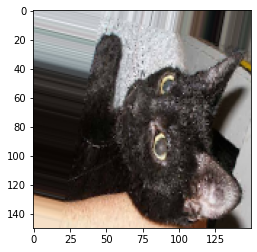

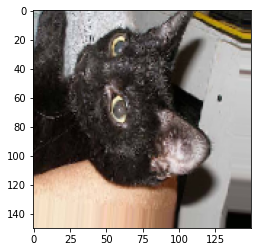

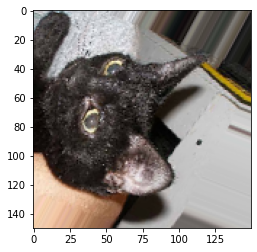

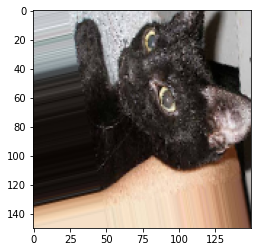

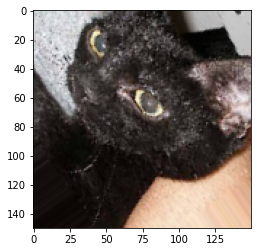

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

### Añadir Data Augmentation al preprocesamiento

In [ ]:
# Agregar cambio de escala, rango_de_rotación, rango_de_cambio_de_ancho, rango_de_cambio_de_altura,
# shear_range, zoom_range y volteo horizontal a nuestro ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# los datos de validación no deben aumentarse!
val_datagen = ImageDataGenerator(rescale=1./255)

# Imágenes de entrenamiento en lotes de 32 usando val_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=20,
     
        class_mode='binary')

# Imágenes de validación en lotes de 32 usando val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Añadir Dropout

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

img_input = layers.Input(shape=(150, 150, 3))

x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)

model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Entrenamiento

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/30
100/100 - 77s - loss: 0.9976 - acc: 0.5090 - val_loss: 0.6863 - val_acc: 0.6150 - 77s/epoch - 766ms/step
Epoch 2/30
100/100 - 69s - loss: 0.7113 - acc: 0.5445 - val_loss: 0.6784 - val_acc: 0.5910 - 69s/epoch - 690ms/step
Epoch 3/30
100/100 - 66s - loss: 0.6907 - acc: 0.5845 - val_loss: 0.6619 - val_acc: 0.6450 - 66s/epoch - 665ms/step
Epoch 4/30
100/100 - 67s - loss: 0.6744 - acc: 0.6025 - val_loss: 0.6383 - val_acc: 0.5890 - 67s/epoch - 669ms/step
Epoch 5/30
100/100 - 66s - loss: 0.6634 - acc: 0.6300 - val_loss: 0.6163 - val_acc: 0.6550 - 66s/epoch - 655ms/step
Epoch 6/30
100/100 - 66s - loss: 0.6443 - acc: 0.6520 - val_loss: 0.5896 - val_acc: 0.6770 - 66s/epoch - 663ms/step
Epoch 7/30
100/100 - 65s - loss: 0.6180 - acc: 0.6715 - val_loss: 0.6312 - val_acc: 0.6280 - 65s/epoch - 654ms/step
Epoch 8/30
100/100 - 66s - loss: 0.6243 - acc: 0.6550 - val_loss: 0.5825 - val_acc: 0.7060 - 66s/epoch - 664ms/step
Epoch 9/30
100/100 - 65s - loss: 0.6142 - acc: 0.6745 - val_loss: 0.5487

### *Evaluar los resultados*

Text(0.5, 1.0, 'Training and validation loss')

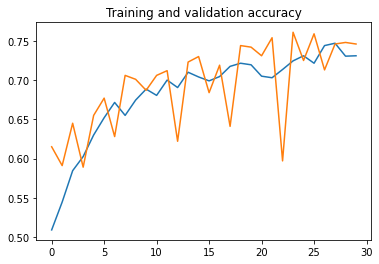

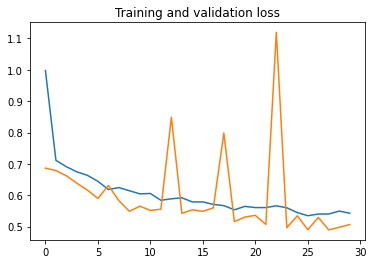

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

Vemos que es un modelo mejorado. Ya no estamos sobreajustando y hemos ganado ~3 puntos porcentuales de precisión de validación (vea la línea naranja en el gráfico superior). De hecho, a juzgar por nuestro perfil de entrenamiento, podríamos seguir ajustando nuestro modelo durante más de 30 épocas y probablemente podríamos llegar a ~80 %